In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter


In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.datasets as datasets
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.conditioning_lib as conditioning_lib
from src.user_encoding_lib import UserEncoder


In [2]:
config_dir = 'runs/Jul25_16-56-35'
config_file = 'config.json'

# Load config file
with open(os.path.join(config_dir, config_file), 'r') as f:
    config = json.load(f)
    

In [3]:
trainset, valset, conditioner, user_ids, condition_set, X_test, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Loaded metadata for 1 provinces
Uniqe provinces are: ['Gipuzkoa']
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Number of (subsampled/filtered) users....6830
Number of (subsampled) days...............365
Number of (aggregated) features............24
Mean of enrolments: 28.59
Number of Training Points: 2065749
Number of Validation Points: 229527


In [4]:
# Load model
num_features = valset.inputs.shape[1]
model = CVAE(input_dim=num_features, conditioner=conditioner, **config["model"])
model.load(config_dir)

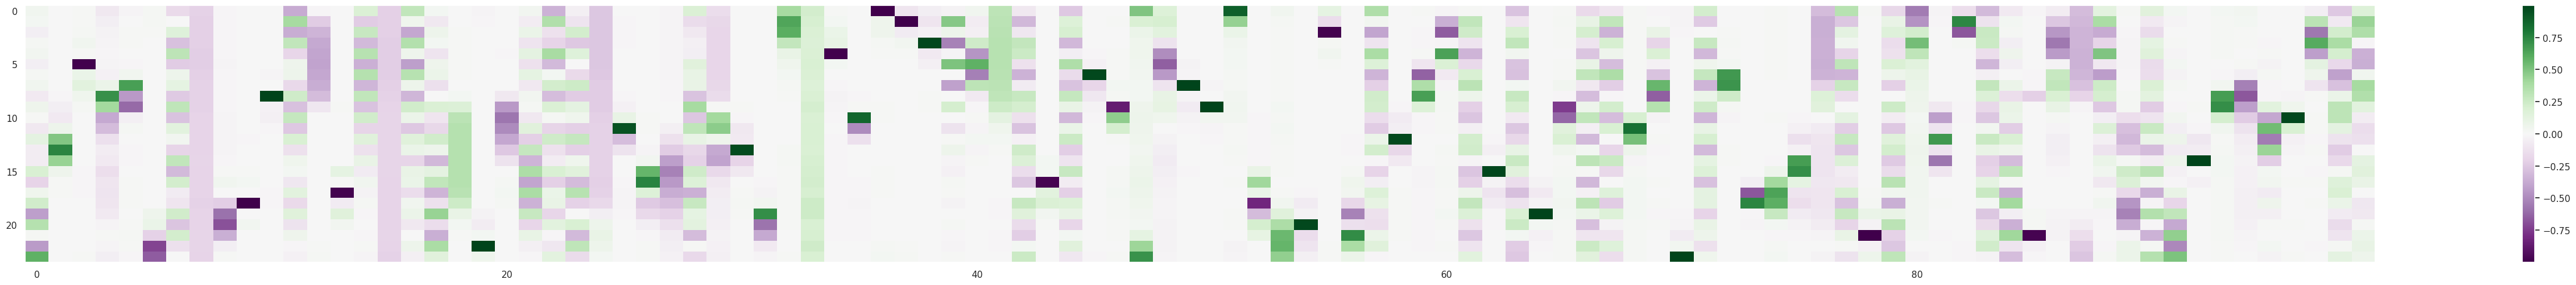

In [5]:
fig, ax = plt.subplots(figsize=(50,5))
fig.tight_layout()
im = ax.imshow(model.decoder.get_SigmaMapper().detach().numpy(), aspect='auto', cmap='PRGn', interpolation='none')
ax.grid(False)
fig.colorbar(im, ax=ax)
plt.show()

In [6]:
X_val = valset.inputs
conditions_val = condition_set["val"]
x_val = torch.tensor(X_val).float()
x_val_conditions = conditions_val.copy()
x_rec, z_rec = model.reconstruct(x_val, torch.tensor(conditioner.transform(x_val_conditions)).float())

In [7]:
LOG_SPACE = config["data"]["scaling"]["log_space"]
ZERO_ID = config["data"]["scaling"]["zero_id"]
SHIFT = config["data"]["scaling"]["shift"]

x_rec_mu = x_rec["params"]["mu"].detach().squeeze(0)
x_rec_sigma = model.decoder.get_marginal_sigmas(x_rec["params"]).detach().squeeze(0)

x_val_Sigma = model.decoder.create_covariance_matrix(x_rec["params"]).squeeze(0).detach()
x_val_Corr = x_val_Sigma / (x_rec_sigma[...,None]*x_rec_sigma[:,None,:])

x_val_denorm = utils.zero_preserved_log_denormalize(x_val.unsqueeze(0), nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm = utils.zero_preserved_log_denormalize(x_rec_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(x_rec_mu - 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(x_rec_mu + 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()

Reconstruction Log-Likelihood: -3.5560
KL Divergence: 3.6525
**************************************************
Top-5 Mimimum RLL: [-1846.2612   -479.87674  -365.44397  -278.5559   -266.37308] (Data index: [ 38360  25247  42079 224990  88707])
Top-5 Maximum KL: [20.736862 20.76235  20.806808 20.858622 21.81741 ] (Data index: [ 68750 144978 170077  59010 181762])


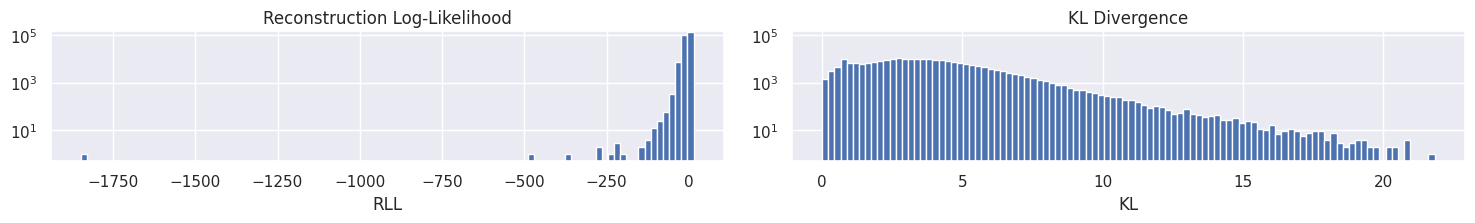

In [8]:
rll_val = model.reconstruction_loglikelihood(x_val, x_rec["params"]).detach().numpy()
kl_val = model.kl_divergence(z_rec["params"], prior_params=model.prior_params).detach().numpy()

print(f"Reconstruction Log-Likelihood: {rll_val.mean():.4f}")
print(f"KL Divergence: {kl_val.mean():.4f}")
print("*"*50)
print(f"Top-5 Mimimum RLL: {np.sort(rll_val)[:5]} (Data index: {np.argsort(rll_val)[:5]})")
print(f"Top-5 Maximum KL: {np.sort(kl_val)[-5:]} (Data index: {np.argsort(kl_val)[-5:]})")
fig, ax = plt.subplots(1,2, figsize=(15,2))
fig.tight_layout()
h_rll = ax[0].hist(rll_val, bins=100, log=True)
ax[0].set_title("Reconstruction Log-Likelihood")
ax[0].set_xlabel("RLL")
h_kl = ax[1].hist(kl_val, bins=100, log=True)
ax[1].set_title("KL Divergence")
ax[1].set_xlabel("KL")
ax[0].set_ylim(0.5, max(h_rll[0].max(), h_kl[0].max())*1.1)
ax[1].set_ylim(0.5, max(h_rll[0].max(), h_kl[0].max())*1.1)
plt.show()

In [14]:
val_data_idx = 38360

print(f"User ID: {user_ids['val'][val_data_idx]}")
print("*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in x_val_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[val_data_idx]]))

User ID: 2624
*************************
Condition           Value
months              6.00
weekdays            2.00
users               0.05 0.05 8.69 0.05 344.41 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05


In [18]:
print(f"Reconstruction Log-Likelihood: {rll_val[val_data_idx]}")
print("*"*100)
print(f"KL Divergence: {kl_val[val_data_idx]}")
print("*"*100)
print(f"Eigenvalues: {torch.linalg.eigvalsh(x_val_Sigma[val_data_idx])}")
print("*"*100)
print(f"Marginal Variances: {x_val_Sigma[val_data_idx].diag().detach()}")
print("*"*100)
print(f"sigma values: {x_rec['params']['sigma'][0,val_data_idx]}")

Reconstruction Log-Likelihood: -1846.26123046875
****************************************************************************************************
KL Divergence: 8.90233325958252
****************************************************************************************************
Eigenvalues: tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0531, 0.6376])
****************************************************************************************************
Marginal Variances: tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0503, 0.0500, 0.6348,
        0.0509, 0.0513, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0501, 0.0500, 0.0500, 0.0501, 0.0516, 0.0513])
****************************************************************************************************
sigma values: tensor([1.0000e-04, 1.0000e-04, 1.

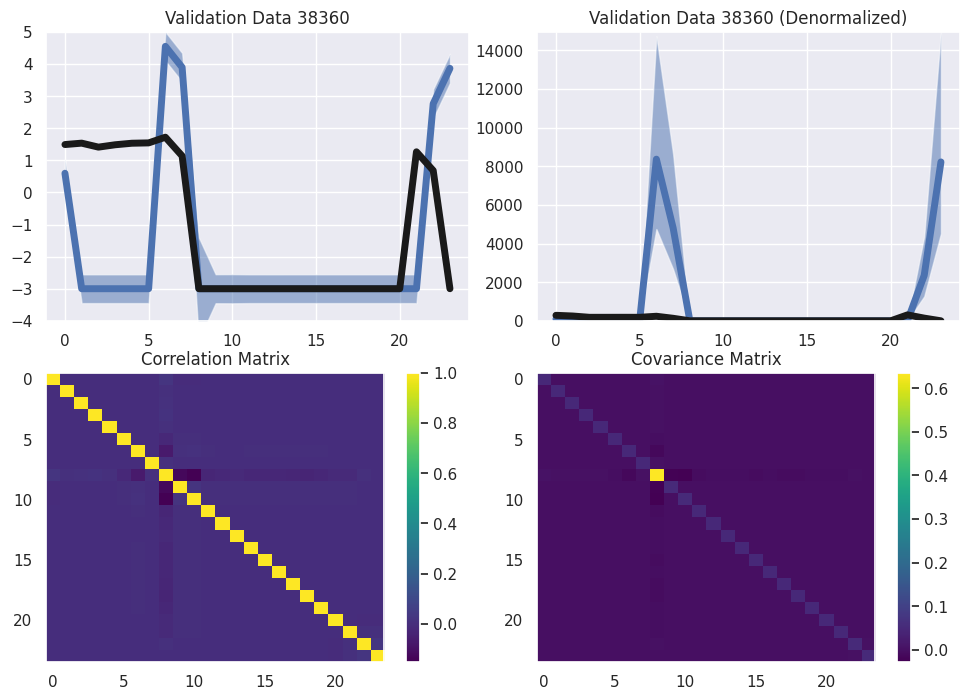

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_rec_mu[val_data_idx].detach().numpy(), lw=5)
ax[0,0].fill_between(np.arange(x_rec_mu.shape[1]), (x_rec_mu-2*x_rec_sigma)[val_data_idx], (x_rec_mu+2*x_rec_sigma)[val_data_idx], alpha=0.5)
ax[0,0].plot(x_val[val_data_idx].numpy(), lw=5, color='k')
ax[0,0].set_title(f"Validation Data {val_data_idx}")
ax[0,0].set_ylim(-4, 5)

ax[0,1].plot(x_rec_denorm[val_data_idx].T, lw=5)
ax[0,1].fill_between(np.arange(x_rec_denorm.shape[1]), x_rec_denorm_sigma_low[val_data_idx], x_rec_denorm_sigma_high[val_data_idx], alpha=0.5)
ax[0,1].plot(x_val_denorm[val_data_idx].T, lw=5, color='k')
ax[0,1].set_title(f"Validation Data {val_data_idx} (Denormalized)")
ax[0,1].set_ylim(0, max(x_rec_denorm_sigma_high[val_data_idx].max(),500))

im = ax[1,0].imshow(x_val_Corr[val_data_idx], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)

im = ax[1,1].imshow(x_val_Sigma[val_data_idx], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()